# Calculation of SII for speech signal at the BCD side (70 dB) and noise at the best ear side (65 dB), both with the ISTS spectrum

25-04-2022 GC

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from math import log10 as log10
from math import e as euler

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def band_names():
    # return list with column names for results table
    frequencies = [125, 160, 200, 250, 315, 400, 500, 630, 800, 1000, 1250, 1600, 2000, 2500, 3150, 4000, 5000, 6300, 8000]
    l = list()
    for f in frequencies:
        st = 'f_' + str(f) + '_Hz'
        l.append(st)
    return l

In [4]:
def change_f_columns_names(df):
    df = df.T
    df.insert(0, 'band_name', band_names())
    df.set_index('band_name', drop=True, inplace=True)
    df.index.name = None
    df = df.T
    return df

In [5]:
def read_AC_thresholds():
    # function to read threshold in dB SPL op de eardrum
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/AC_thresholds_third.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df = df.drop(['f_125_Hz'], axis=1)
    df.set_index('Study_ID', inplace=True)
    return df

In [6]:
def order_columns_BCdata(df):
    # set BC data low freq. = data at 250 Hz
    for f in ['f_160_Hz', 'f_200_Hz']: df[f] = df['f_250_Hz']
    ordered_columns = ['f_160_Hz', 'f_200_Hz', 'f_250_Hz', 'f_315_Hz', 'f_400_Hz', 'f_500_Hz', 
                       'f_630_Hz', 'f_800_Hz', 'f_1000_Hz', 'f_1250_Hz', 'f_1600_Hz', 'f_2000_Hz', 
                       'f_2500_Hz', 'f_3150_Hz', 'f_4000_Hz', 'f_5000_Hz', 'f_6300_Hz', 'f_8000_Hz']
    df = df[ordered_columns]
    return df

In [7]:
def read_BC_thresholds():
    # function to read threshold in dB FL
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/BC_dir_thr_third.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    df = order_columns_BCdata(df)
    return df

In [8]:
def read_BCD_output_65():
    # function to read BCD output
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/output_BCD_65dB.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    df = order_columns_BCdata(df)
    return df

In [9]:
def read_BCD_output_55():
    # function to read BCD output
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/output_BCD_55dB.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    df = order_columns_BCdata(df)
    return df

In [10]:
def read_ISTS_SPL():
    # function to read ISTS dB SPL for 1/3 thirdbands, 65 dB & 55 dB
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)
    col_to_use = list(range(20))
    df = pd.read_excel(p_in, sheet_name='ISTS_sound_pressure', 
                       header=0, nrows=2, usecols=col_to_use)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Signal'})
    df = df.set_index(['Signal'])
    df = change_f_columns_names(df)
    df = df.drop('f_125_Hz', axis = 1)
    s65 = pd.Series(df.iloc[0])
    s55 = pd.Series(df.iloc[1])
    return (s65, s55)

In [11]:
def read_HRTF():
    # function to read HRTF data for the AC path, collected by Stenfelt
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)
    col_to_use = list(range(20))
    df = pd.read_excel(p_in, sheet_name='HRTF_KEMAR_Stenfelt', 
                       header=0, nrows=3, usecols=col_to_use)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Angle'})
    df = df.set_index(['Angle'])
    df = change_f_columns_names(df)
    df = df.drop('f_125_Hz', axis = 1)
    df = df.round(1)
    s0 = pd.Series(df.iloc[0])
    s90 = pd.Series(df.iloc[1])
    s270 = pd.Series(df.iloc[2])
    return (s0, s90, s270)

In [12]:
def read_HRTF_BCD():
    # function to read HRTF data for the BC path, collected by Stenfelt
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)
    col_to_use = list(range(20))
    df = pd.read_excel(p_in, sheet_name='HRTF_BAHA_Stenfelt', header=0, nrows=3, usecols=col_to_use)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Angle'})
    df = df.set_index(['Angle'])
    df = change_f_columns_names(df)
    df = df.drop('f_125_Hz', axis = 1)
    df = df.round(1)
    s0 = pd.Series(df.iloc[0])
    s90 = pd.Series(df.iloc[1])
    s270 = pd.Series(df.iloc[2])
    return (s0, s90, s270)

In [13]:
def ISTS_HRTF_65():
    # ISTS 65 dB corrected with HRTF for 0, 90 and 270 degrees, return list of 3 pd.Series
    ists65 = read_ISTS_SPL()[0]
    hrtf = read_HRTF()
    res = list()
    for s in hrtf:
        corr = s + ists65
        res.append(corr)
    return res

In [14]:
def ISTS_HRTF_55():
    # ISTS 55 dB corrected with HRTF for 0, 90 and 270 degrees, return list of 3 pd.Series
    ists55 = read_ISTS_SPL()[1]
    hrtf = read_HRTF()
    res = list()
    for s in hrtf:
        corr = s + ists55
        res.append(corr)
    return res

In [15]:
def read_ANSI():
    # function to read data from tabel 3 from ANSI norm
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='Tabel3_SII', header=0, index_col=0).T
    df.insert(0, 'f_125_Hz', df['160_Hz'])
    df = change_f_columns_names(df)
    df = df.drop('f_125_Hz', axis = 1).T
    return df

In [16]:
def read_importance():
    # function to read importance values from xlsx file
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)    
    df = pd.read_excel(p_in, sheet_name='SII_importance_SPIN', header=0, nrows=1)
    df = df.drop(['Unnamed: 0'], axis=1)
    df = change_f_columns_names(df)
    df = df.drop('f_125_Hz', axis = 1)
    s = pd.Series(df.iloc[0])
    return s

In [17]:
def band_audibility(sl):
    ba = (sl + 15) / 30
    ba = ba.fillna(-999)
    ba = ba.where(ba<=1, 1)
    ba = ba.replace(-999, 999)
    ba = ba.where(ba>=0, 0)
    ba = ba.replace(999, pd.NA)
    return ba

In [18]:
def band_intelligibility(sl):
    ba = band_audibility(sl)
    importance = read_importance()
    bi = ba * importance
    return bi

In [19]:
def speech_intelligibility_index(sl):
    bi = band_intelligibility(sl)
    SII = bi.sum(axis=1, min_count=18)
    SII = SII.round(4)
    return SII

In [20]:
def calculate_B(V, N):
    ''' calculation of B, Ansi S3.5 1997 4.3.2.2
    B is the larger value between equivalent noise spectrum level N 
    and self-speech masking spectrum level V'''
    b = pd.concat([V, N], axis='columns')
    l = list()
    for col in b.columns: 
        if col not in l: l.append(col)
    bb = pd.DataFrame()
    for col in l: 
        bb[col] = b[col].max(axis=1)
    bb = bb.astype('float64')
    bb = bb.round(1)
    return bb

In [21]:
def calculate_C(V, N):   
    # calculation of C, slope of spread of masking, Ansi S3.5 1997 4.3.2.2
    B = calculate_B(V, N)
    l = list()
    c = pd.DataFrame()
    for col in B.columns:
        f = int(col.split('_')[1])
        c[col] = -80 + 0.6 * (B[col] + 10 * log10(f) - 6.353)
    return c

In [22]:
def calculate_Z(V, N):
    
    # calculation of Z, equivalent masking spectrum level, Ansi S3.5 1997 4.3.2.5
    b = calculate_B(V, N)
    c = calculate_C(V, N)

    # make list with values of CF of 1/3 octave bands (160-8000 Hz)
    clmns = b.columns
    l = list()
    for col in clmns: 
        f = int(col.split('_')[1])
        l.append(f)     
    
    d ={0: (b.iloc[:, 0]).to_numpy()}    # make dict, value Z=B for 160 Hz, ANSI 4.3.2.4
    for i in range (1, 18):              # equation 9, i index f band > 160 Hz
        n2 = pd.array([0]*len(b))        # make null array for update with summation 

        for k in range (0, i-1):         # k, summation index, range 
            bb = (b.iloc[:, k]).to_numpy()
            cc = c.iloc[:, k].to_numpy()
            fi = l[i]
            fk = l[k]
            r = log10(0.89 * fi / fk)
            n3 = 10 ** (0.1 * (bb + 3.32 * cc * r))
            n2 += n3                     # summation term in eq.9

        n1 = 10 ** (0.1 * N.iloc[:, i])
        z = 10 * np.log10(n1 + n2)       # equation 9
        d1 = {i : z}
        d.update(d1)                     # dict {f : array z}   
    
    z = pd.DataFrame(d)                  # convert dict in DataFrame
    
    lc = clmns.to_list()                 # set back names 1/3 octave bands (eg 160_Hz)
    dc = dict()
    for j in range(len(lc)):  
        up = {j: lc[j]}
        dc.update(up)
    z = z.rename(columns=dc)
    z = z.astype('float')
    z = z.round(1)
    return z

In [23]:
def calculate_X(thresholds):
    # calculation of X, equivalent internal noise for AC or BC path, Ansi S3.5 1997 4.4
    ansi = read_ANSI()
    internal_noise = ansi.iloc[:, 4]
    x = thresholds.add(internal_noise,  axis='columns')
    x = x.astype('float64')
    x = x.round(1)
    return x

In [24]:
def calculate_D(V, N, thresholds):
    # calculation of disturbance D, Ansi S3.5 1997 4.5
    Z = calculate_Z(V, N)
    X = calculate_X(thresholds)
    idx = X.index
    Z.insert(0, 'idx', idx)
    Z.set_index('idx', inplace=True)
    Z.index.names = [None]
    filter_x = (Z < X)
    take_x = X[filter_x]
    D = take_x.fillna(value=Z)
    D = D.astype('float64')
    D = D.round(1)
    return D

In [25]:
def combination_path (acpath, bcpath):
    # make mask filters bc vs ac
    mask_filter = acpath >= bcpath
    mask_filter_inv = ~(mask_filter)
    filtered1 = acpath[mask_filter]
    filtered1.fillna(value=0, inplace=True)
    filtered2 = (bcpath)[mask_filter_inv]
    filtered2.fillna(value=0, inplace=True)
    combi = filtered1 + filtered2
    return combi

In [26]:
def CVC_transfer_function(sii):
    # CVC score calculation as a funtion of SII
    n = 0.9
    q = 0.6
    p = 1
    cvc_score = round((1-10**(-(sii*p)/q))**n, 2)
    cvc_score = ((cvc_score*100).astype(int).astype(float))/100
    return cvc_score

In [27]:
def set_index_studyid(df):
    idx = read_BC_thresholds().index
    df.insert(0, 'idx', idx)
    df.set_index('idx', inplace=True)
    df.index.names = ['Study_ID']
    return df

In [28]:
def make_lenght_and_index(s):
    bct = read_BC_thresholds()
    df = pd.concat([s] * len(bct), axis=1).T
    df = set_index_studyid(df)
    return df

In [29]:
noise_level = 65
speech_level = 70
delta = speech_level - noise_level # S/N

Calculation of SII for AC path

In [30]:
# read AC thresholds
act = read_AC_thresholds()

In [31]:
# speech spectrum level 
e_65_270 = ISTS_HRTF_65()[2] + delta    # speech source on the BCD side (270 degrees)
E_65_270 = make_lenght_and_index(e_65_270) # modifica

In [32]:
# calculation of self-speech masking spectrum level V, Ansi S3.5 1997 4.3.2.1
V_65_best_ear = E_65_270 - 24    # speech source on the BCD side (270 degrees)

In [33]:
# calculation of equivalent noise spectrum level N, Ansi S3.5 1997 4.3.2.2
n_best_ear = ISTS_HRTF_65()[1]  # noise source on the best ear side (90 degrees)
N_best_ear = make_lenght_and_index(n_best_ear) # modifica

In [34]:
# calculation of disturbance D, Ansi S3.5 1997 4.5
disturbance_ac = calculate_D(V_65_best_ear, N_best_ear, act)

In [35]:
# calculation of SII for AC path
unmasked_ac = E_65_270.subtract(disturbance_ac, axis='columns') # ANSI step 7 (4.7) E - D
sii_ac_s270_n90 = speech_intelligibility_index(unmasked_ac)

In [36]:
# calculation of CVC-score for AC path
cvc_ac_s270_n90 = CVC_transfer_function(sii_ac_s270_n90)

Calculation of SII for BC path

In [37]:
# read BC thresholds
bct = read_BC_thresholds()  # modifica

In [38]:
# read the output of the BCD, measured on the skull simulator with input ISTS 65 dB
BCD_out_65 = read_BCD_output_65()  # modifica

In [39]:
# read the output of the BCD, measured on the skull simulator with input ISTS 55 dB
#BCD_out_55 = read_BCD_output_55()  # modifica

In [40]:
# read head related transfer function for the BCD, signal longitudinal on BCD side
HRTF_BCD_90 = read_HRTF_BCD()[1]

In [41]:
# calculation of equivalent speech spectrum level Ansi S3.5 1997 4.2
E_65_90 = BCD_out_65 + HRTF_BCD_90

In [42]:
# calculation of self-speech masking spectrum level V, Ansi S3.5 1997 4.3.2.1
V_65_BCD = E_65_90 - 24              # speech source on the BCD side (90 degrees)

In [43]:
# read head related transfer function for the BCD, signal on best ear side, opposite to BCD
HRTF_BCD_270 = read_HRTF_BCD()[2]

In [44]:
# calculation of equivalent noise spectrum level N, Ansi S3.5 1997 4.3.2.2
# noise source on the best ear side (270 degrees)
N_BCD = BCD_out_65 + HRTF_BCD_270 - (delta)   

In [45]:
# calculation of disturbance D, Ansi S3.5 1997 4.5
disturbance_bc = calculate_D(V_65_BCD, N_BCD, bct)

In [46]:
#calculation of SII for BC path
unmasked_bc = E_65_90.subtract(disturbance_bc, axis='columns') # ANSI step 7 (4.7) E - D
sii_bc_s90_n270 = speech_intelligibility_index(unmasked_bc)

In [47]:
# calculation of CVC-score for BC path
cvc_bc_s90_n270 = CVC_transfer_function(sii_bc_s90_n270)

Adaptation of BC path to AC path to compare both en determine combination path

In [48]:
# difference between air- vs. bone thresholds
kk = act - bct  # modifica

In [49]:
# speech signal BC path
E_65_90 = E_65_90 + kk

In [50]:
# noise BC path
N_BCD = N_BCD + kk

Filtering higher values speech and noise to determine combination path

In [51]:
# make mask filters bc vs ac
# modifica
speech_combi = combination_path (E_65_90, E_65_270)
noise_combi = combination_path (N_BCD, N_best_ear)

Calculation of SII for combination pad

In [52]:
# calculation of self-speech masking spectrum level V, Ansi S3.5 1997 4.3.2.1
V_combi = speech_combi - 24

In [53]:
# calculation of disturbance D, Ansi S3.5 1997 4.5
disturbance_combi = calculate_D(V_combi, noise_combi, act) # modifica

In [54]:
#calculation of SII for BC path
unmasked_combi = speech_combi.subtract(disturbance_combi, axis='columns') # ANSI step 7 (4.7) E - D
sii_combi = speech_intelligibility_index(unmasked_combi)

In [55]:
# calculation of CVC-score for combination path
cvc_combi = CVC_transfer_function(sii_combi)

presentation of results

In [56]:
sii_ac = sii_ac_s270_n90   # modifica
sii_bc = sii_bc_s90_n270
sii_diff = sii_combi - sii_ac

cvc_ac = cvc_ac_s270_n90   # modifica
cvc_bc = cvc_bc_s90_n270
cvc_diff = cvc_combi - cvc_ac

In [57]:
# make Pandas DataFrame with SII results
# modifica
SII_Sbcd65_Nbest65 = pd.concat([sii_ac, sii_bc, sii_combi, sii_diff], axis='columns')
SII_Sbcd65_Nbest65.rename(columns={0:'AC_path', 1:'BC_path', 2:'AC&BC_path', 3: 'diff_combi_AC'}, inplace=True)

SII_Sbcd65_Nbest65

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Study_ID,,,,
34,0.3664,0.7630,0.4969,0.1305
35,0.3664,0.7753,0.5185,0.1521
43,0.3664,0.7843,0.4036,0.0372
47,0.3664,0.7639,0.4712,0.1048
50,0.3664,0.7655,0.3851,0.0187
53,0.3664,0.6931,0.3826,0.0162
54,0.3664,0.7158,0.5294,0.1630
56,0.3664,0.7356,0.5912,0.2248
59,0.3664,0.6867,0.3757,0.0093


In [58]:
# write SII results to csv file in Master directory
fout = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/SNR/SII_Sbcd70_Nbest65.csv'
pout = Path(fout)
SII_Sbcd65_Nbest65.to_csv(pout)

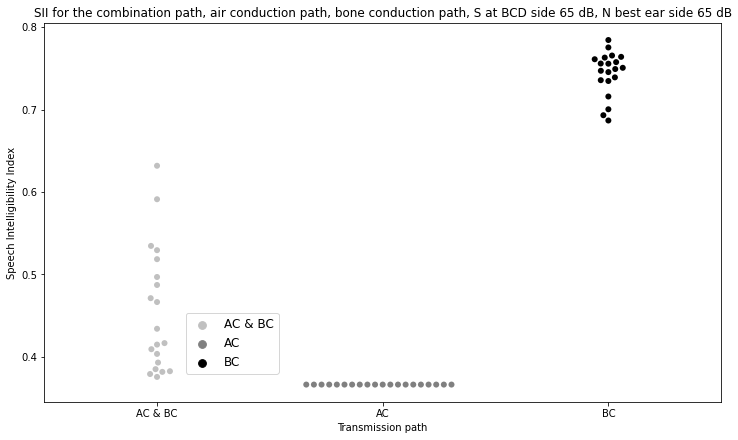

In [59]:
# make a figure to plot SII for the 3 paths
ttl = 'SII for the combination path, air conduction path, bone conduction path, S at BCD side 65 dB, N best ear side 65 dB'
tp = pd.melt(pd.DataFrame( {'AC & BC' : sii_combi, 'AC' : sii_ac, 'BC' : sii_bc }), 
             var_name = 'Transmission path', value_name = 'Speech Intelligibility Index') 

fig, ax = plt.subplots(constrained_layout=True)

fig.set_figheight(6)
fig.set_figwidth(10)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'Speech Intelligibility Index', 
              hue = 'Transmission path', size=6, palette={'silver', 'grey', 'black'})

ax.set_title(ttl)
plt.legend(bbox_to_anchor=(0.20, 0.25), fontsize='large')

plt.show()